In [1]:
import scanpy as sc
import scvelo as scv
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Load data

In [2]:
scvelo_adata = scv.read("data/scvelo.h5ad")
celldancer_adata = scv.read("data/celldancer.h5ad")
deepvelo_adata = scv.read("data/deepvelo.h5ad")
julovelo_adata = scv.read("data/JuloVelo.h5ad")

In [3]:
celldancer_adata.uns["clusters_colors"] = scvelo_adata.uns["clusters_colors"]
julovelo_adata.uns["clusters_colors"] = scvelo_adata.uns["clusters_colors"]

In [4]:
celldancer_adata.obs.clusters = pd.Categorical(celldancer_adata.obs.clusters, categories=['HSC_1', 'HSC_2', 'Ery_1', 'Mono_1', 'Precursors', 'Mono_2', 'DCs', 'Ery_2', 'Mega'], ordered=False)
julovelo_adata.obs.clusters = pd.Categorical(julovelo_adata.obs.clusters, categories=['HSC_1', 'HSC_2', 'Ery_1', 'Mono_1', 'Precursors', 'Mono_2', 'DCs', 'Ery_2', 'Mega'], ordered=False)

# Plot function

In [5]:
def plotting_sort(adata, layer1, layer2, n_convolve, col_color, save = False, save_path = ""):
    gene = adata.var_names
    var_names = [name for name in gene if name in adata.var_names]
    
    time = adata.obs["pseudotime"].values
    time = time[np.isfinite(time)]
    
    X1 = (
        adata[:, var_names].layers[layer1]
        if layer1 in adata.layers.keys()
        else adata[:, var_names].X
    )
    
    X2 = (
        adata[:, var_names].layers[layer2]
        if layer2 in adata.layers.keys()
        else adata[:, var_names].X
    )
    
    df_1 = pd.DataFrame(X1[np.argsort(time)], columns=var_names)
    col = df_1.columns.to_list()
    
    df_2 = pd.DataFrame(X2[np.argsort(time)], columns=var_names)
    df_2 = df_2[col]
    
    weights = np.ones(n_convolve) / n_convolve
    
    for gene in var_names:
    # TODO: Handle exception properly
        try:
            df_1[gene] = np.convolve(df_1[gene].values, weights, mode="same")
            df_2[gene] = np.convolve(df_2[gene].values, weights, mode="same")
        except ValueError as e:
            logg.info(f"Skipping variable {gene}: {e}")
            pass  # e.g. all-zero counts or nans cannot be convolved
    
    max_sort = np.argsort(np.argmax(df_1.values, axis=0))
    df_1 = pd.DataFrame(df_1.values[:, max_sort], columns=df_1.columns[max_sort])
    df_2 = pd.DataFrame(df_2.values[:, max_sort], columns=df_2.columns[max_sort])
    
    scv.utils.strings_to_categoricals(adata)
    
    col_colors = scv.pl.utils.to_list(col_color)
    col_color = []
    for _, col in enumerate(col_colors):
        if not scv.pl.utils.is_categorical(adata, col):
            obs_col = adata.obs[col]
            cat_col = np.round(obs_col / np.max(obs_col), 2) * np.max(obs_col)
            adata.obs[f"{col}_categorical"] = pd.Categorical(cat_col)
            col += "_categorical"
            set_colors_for_categorical_obs(adata, col, palette)
        col_color.append(scv.pl.utils.interpret_colorkey(adata, col)[np.argsort(time)])
        
    with sns.plotting_context("paper"):
        p1 = sns.clustermap(df_1.T, col_colors = col_color, col_cluster = False, row_cluster = False, cmap = "viridis", standard_scale = 0, xticklabels = False, cbar_pos = None)
        if save:
            plt.savefig(os.path.join(save_path, f"{layer1}.png"), dpi = 300)
        plt.close()
        p2 = sns.clustermap(df_2.T, col_colors = col_color, col_cluster = False, row_cluster = False, cmap = "viridis", standard_scale = 0, xticklabels = False, cbar_pos = None)
        if save:
            plt.savefig(os.path.join(save_path, f"{layer2}.png"), dpi = 300)
        plt.close()
        
    
    return p1, p2

# Velocity

## scVelo

saving figure to file figure/scvelo_bone_marrow_velocity.png


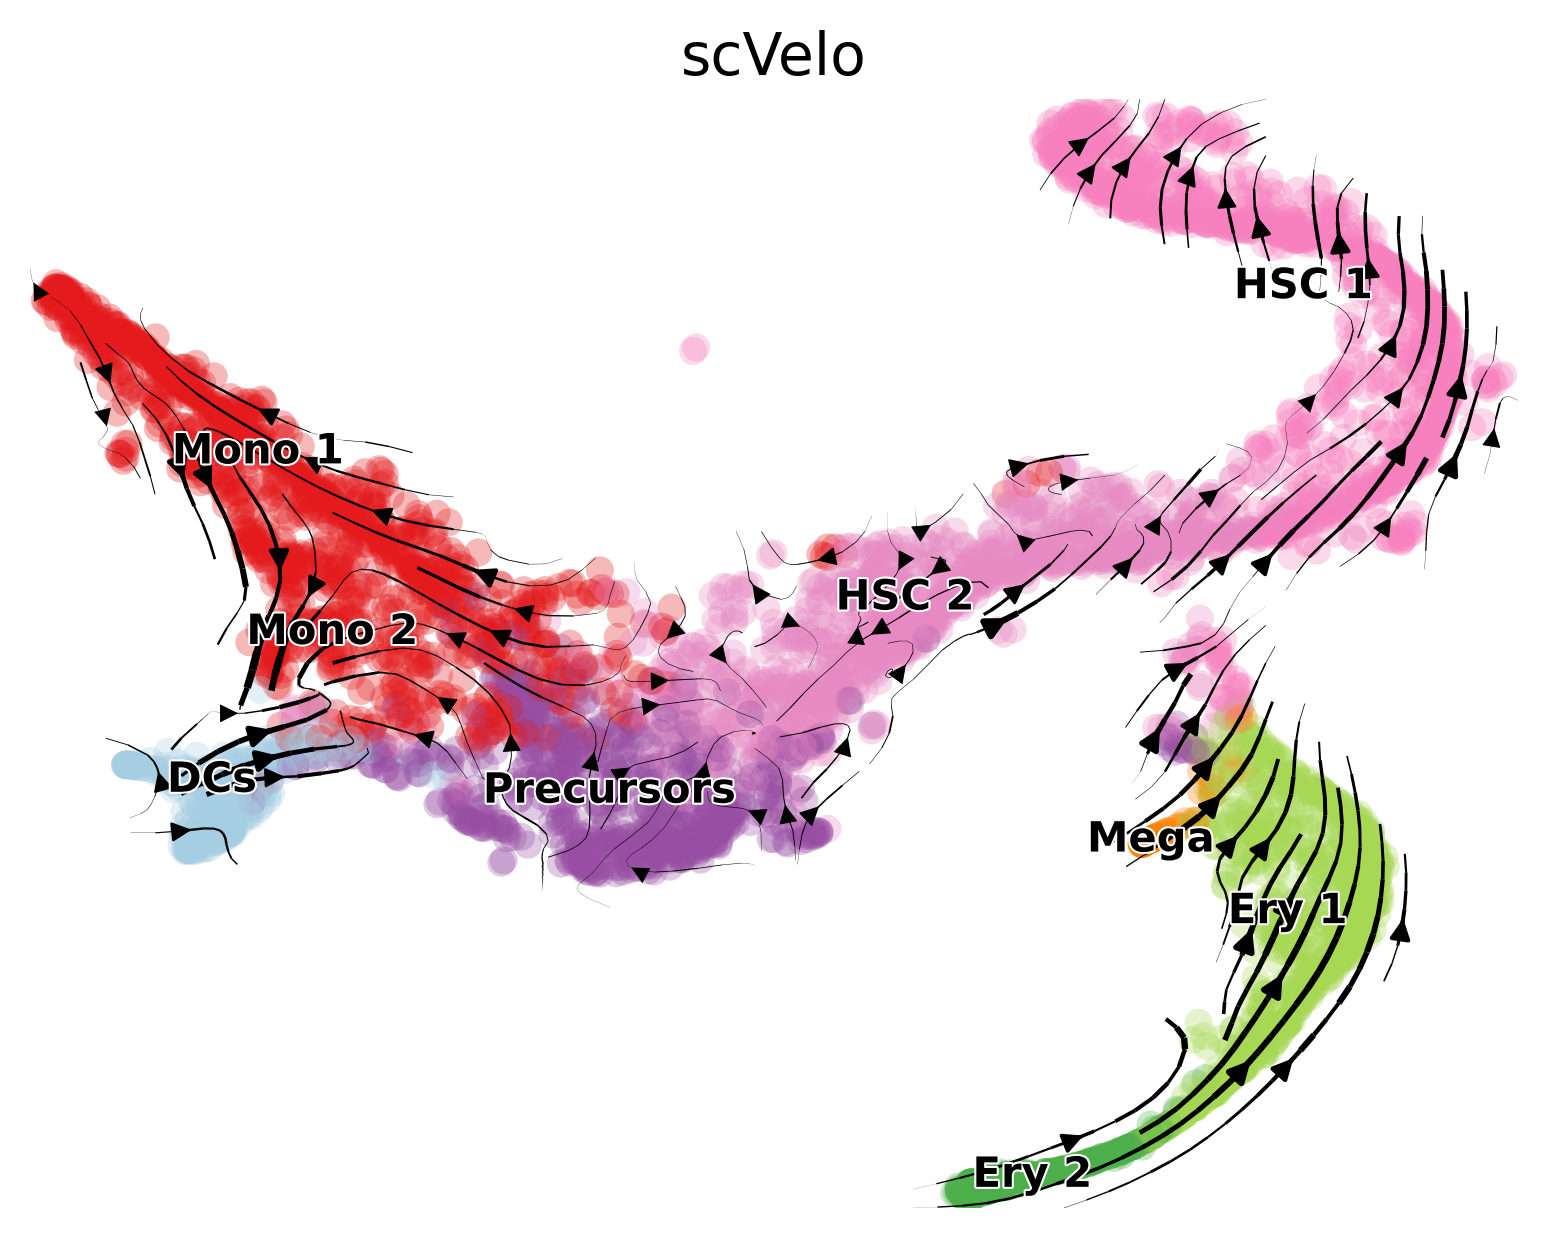

In [6]:
scv.pl.velocity_embedding_stream(scvelo_adata, color = "clusters", title = "scVelo", fontsize = 14, dpi = 300, save = "figure/scvelo_bone_marrow_velocity.png", cutoff_perc = 0)

## DeepVelo

saving figure to file figure/deepvelo_bone_marrow_velocity.png


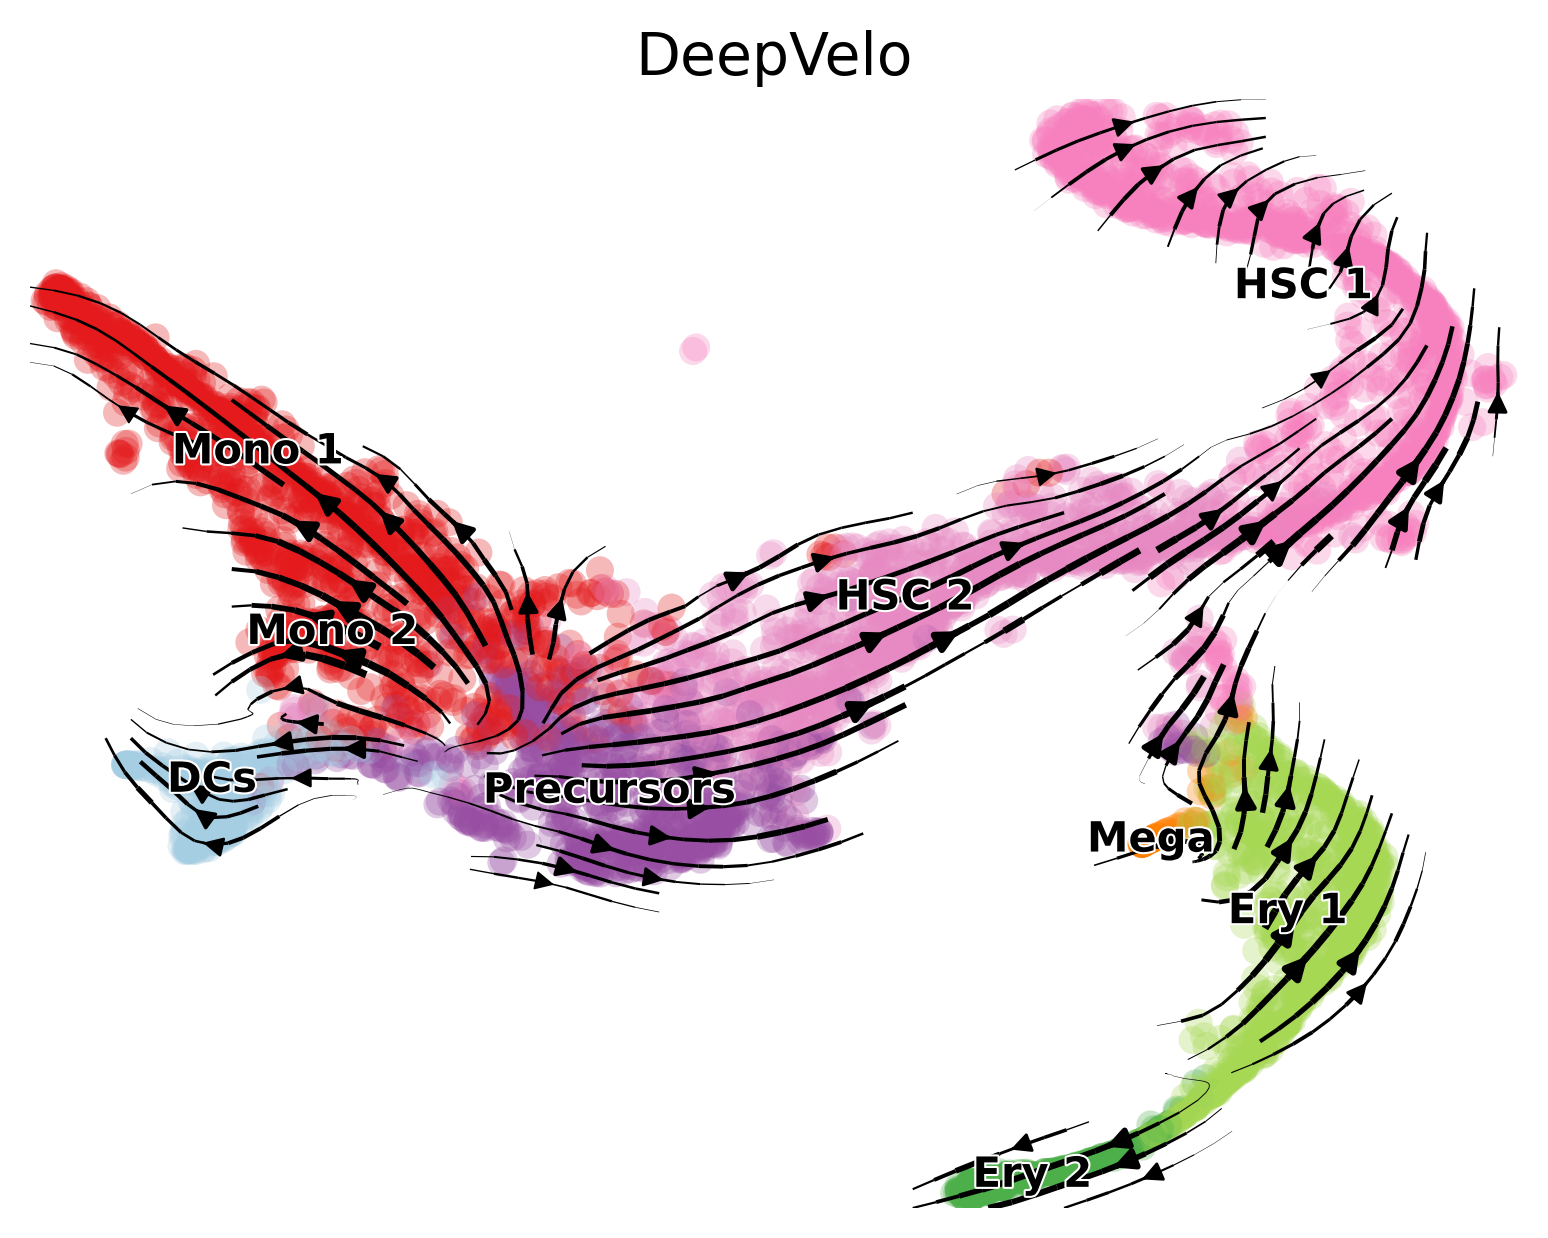

In [7]:
scv.pl.velocity_embedding_stream(deepvelo_adata, color = "clusters", title = "DeepVelo", fontsize = 14, dpi = 300, save = "figure/deepvelo_bone_marrow_velocity.png", cutoff_perc = 0)

## celldancer

saving figure to file figure/celldancer_bone_marrow_velocity.png


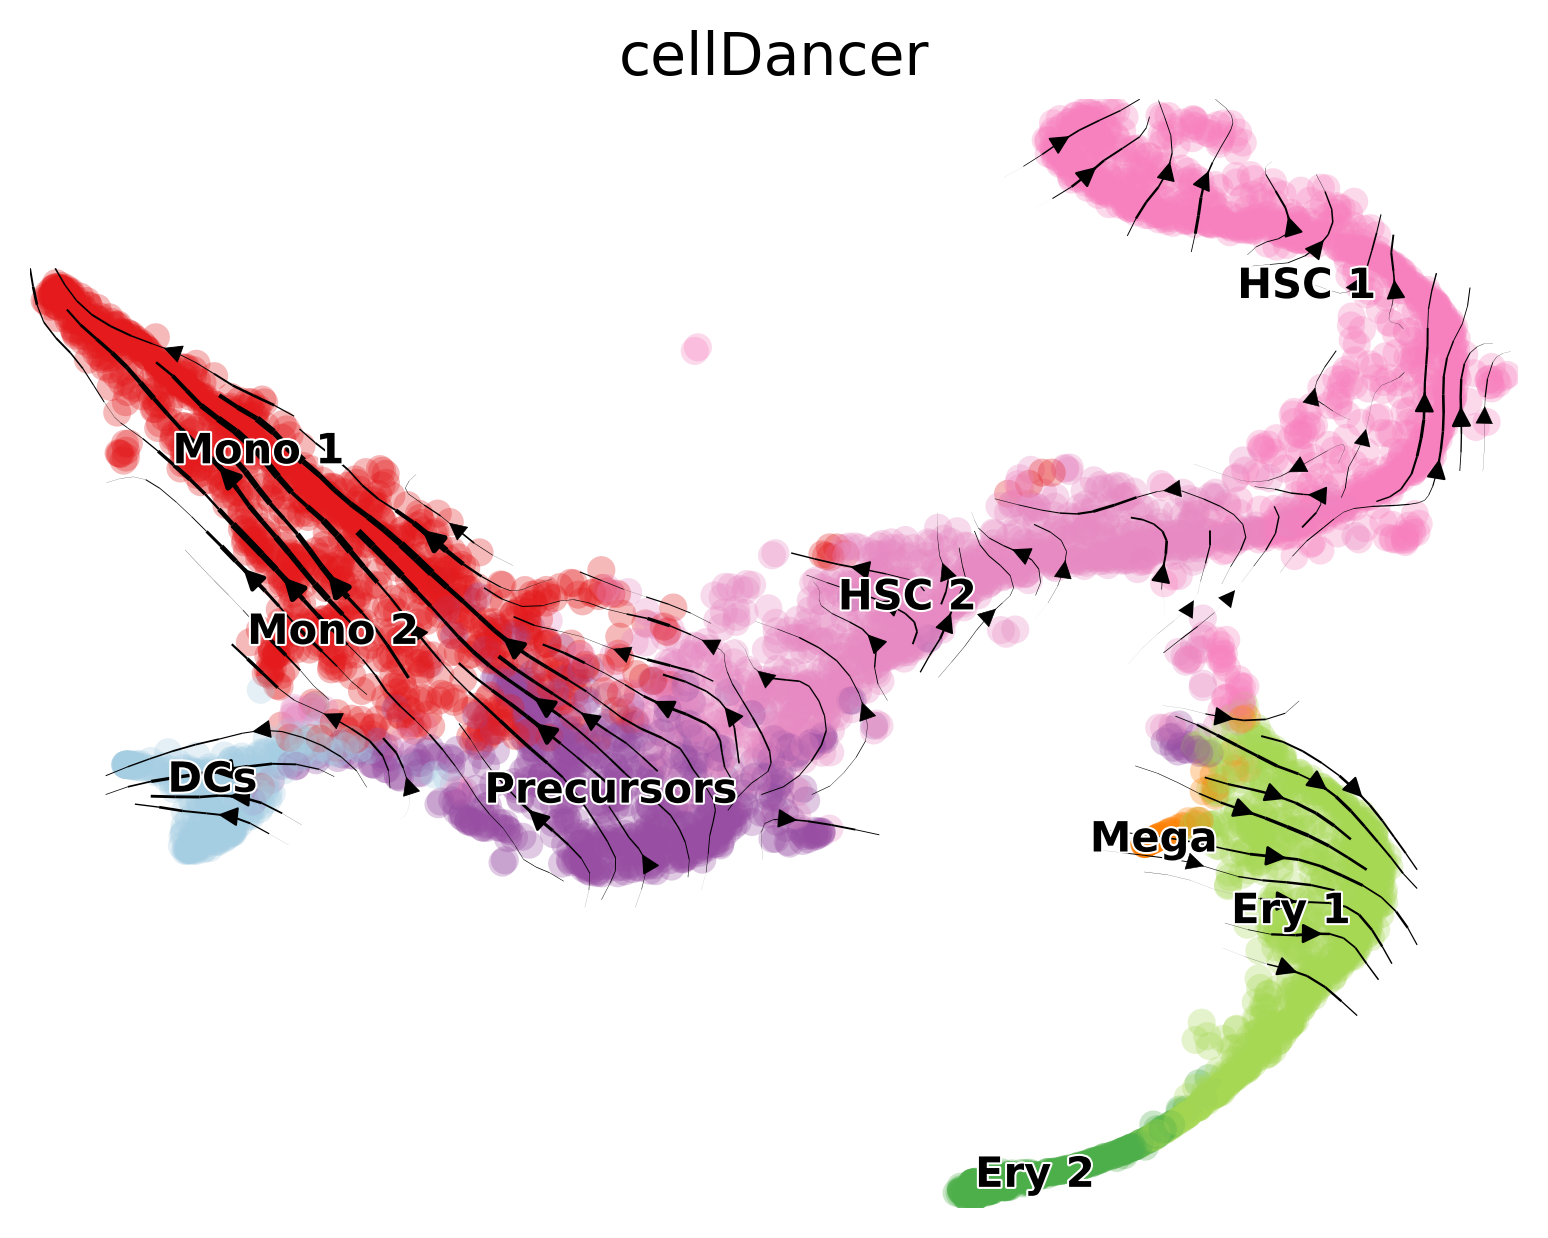

In [8]:
scv.pl.velocity_embedding_stream(celldancer_adata, color = "clusters", title = "cellDancer", fontsize = 14, dpi = 300, save = "figure/celldancer_bone_marrow_velocity.png", basis = "cdr", vkey = "velocity", cutoff_perc = 0)

## JuloVelo

saving figure to file figure/julovelo_bone_marrow_velocity.png


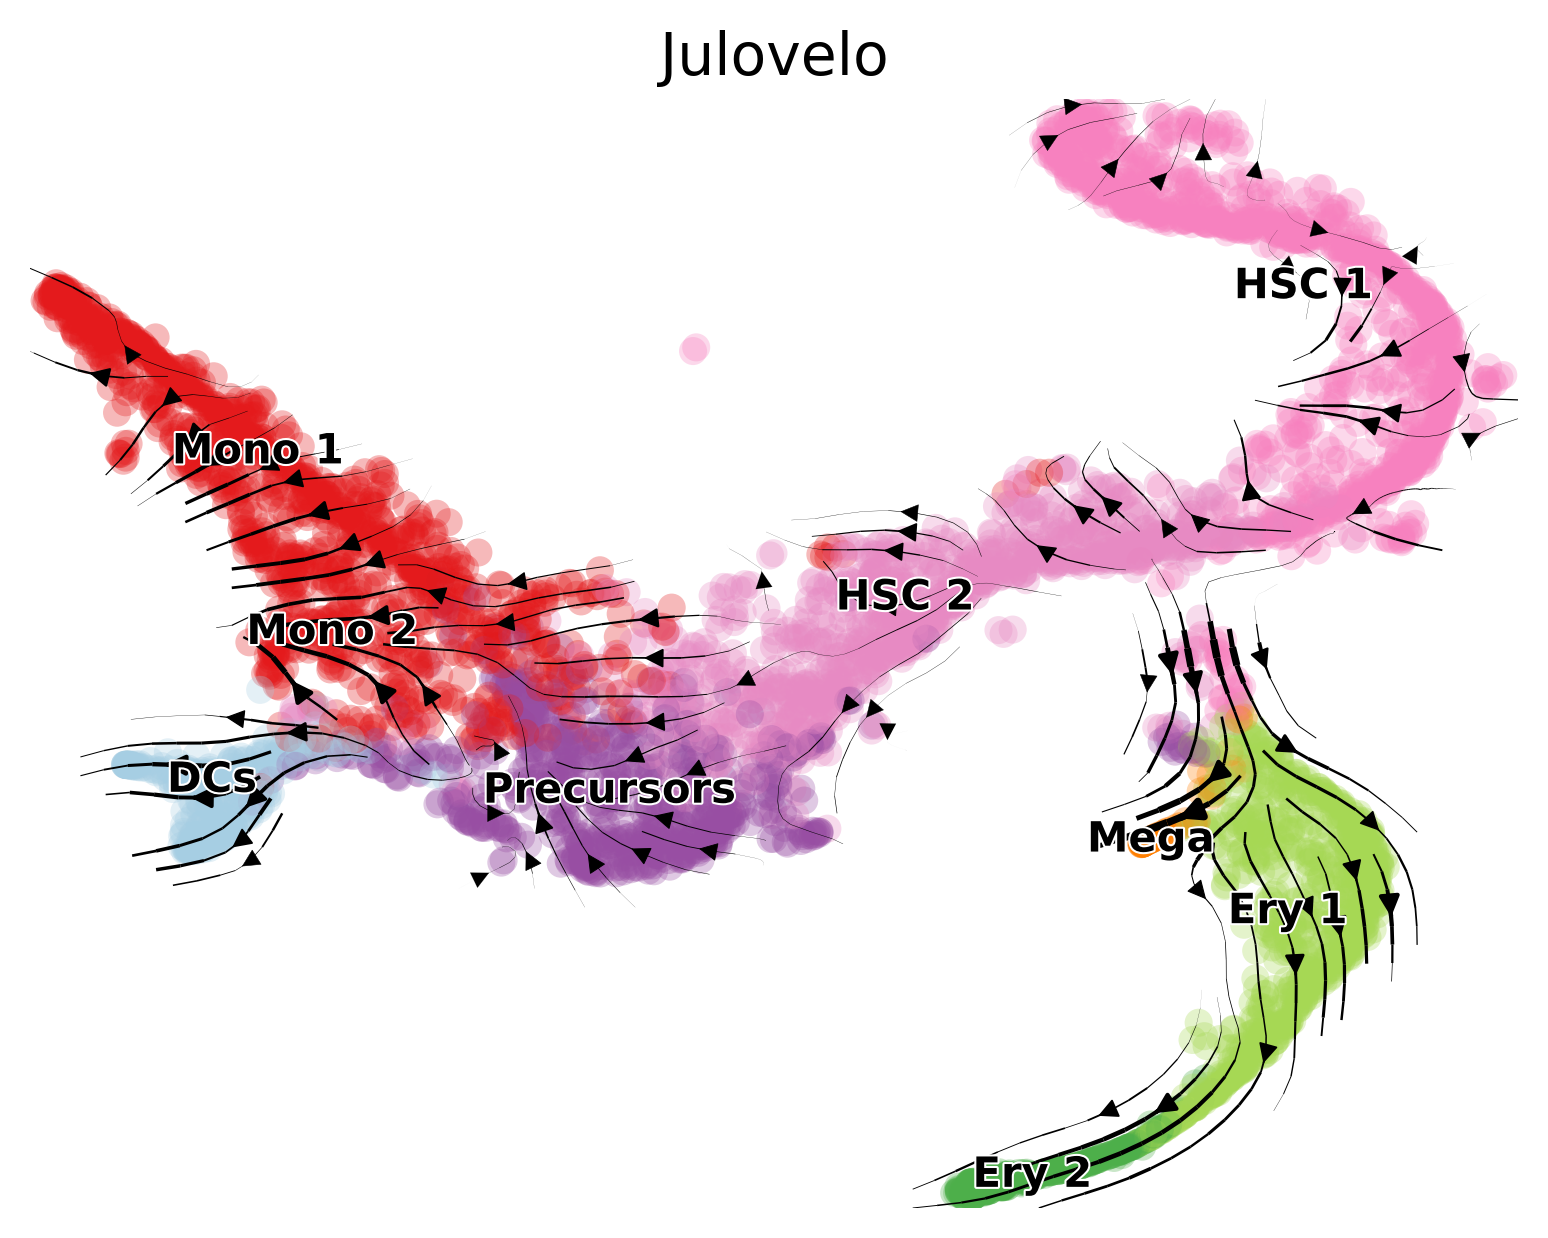

In [9]:
scv.pl.velocity_embedding_stream(julovelo_adata, color = "clusters", title = "Julovelo", fontsize = 14, dpi = 300, save = "figure/julovelo_bone_marrow_velocity.png", cutoff_perc = 0)

# Pseudotime

## ScVelo 

saving figure to file figure/scvelo_bone_marrow_pseudotime.png


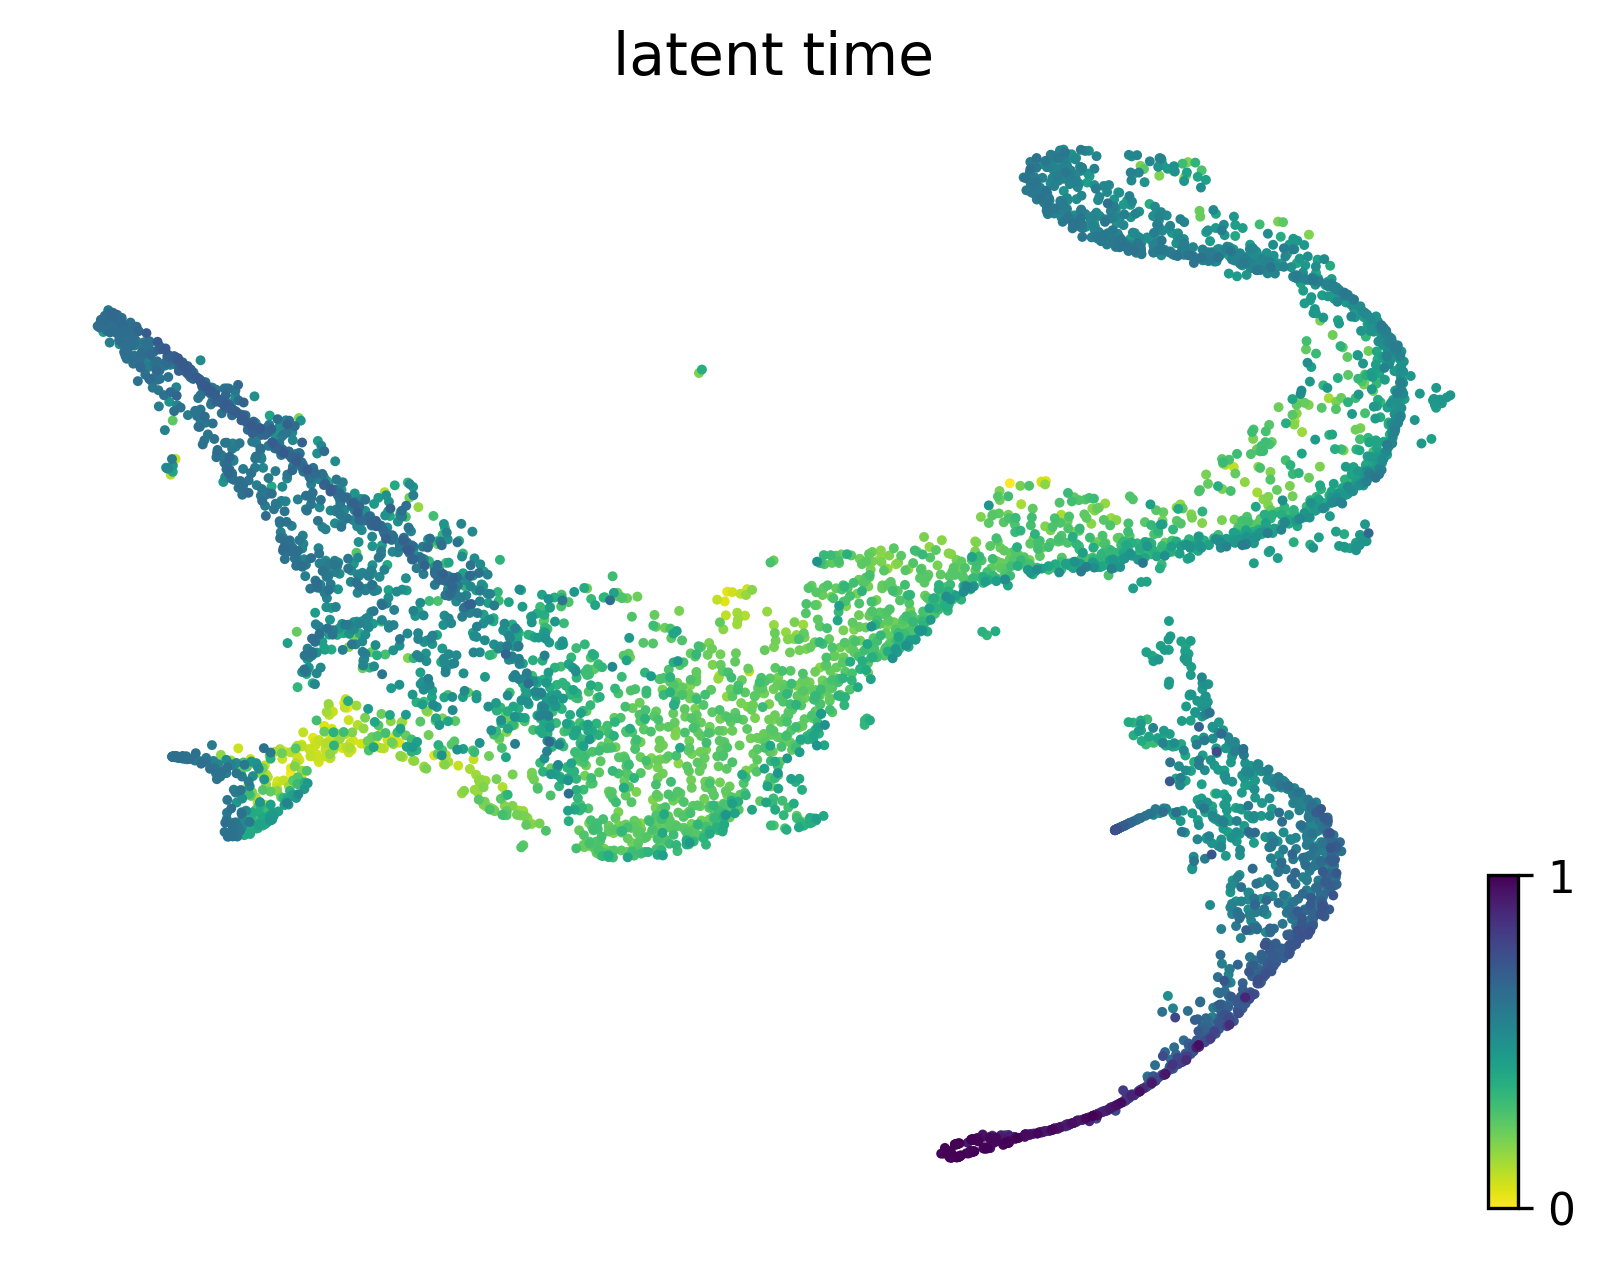

In [10]:
scv.pl.scatter(scvelo_adata, basis = "tsne", color = "latent_time", fontsize = 14, dpi = 300, save = "figure/scvelo_bone_marrow_pseudotime.png")

## DeepVelo

saving figure to file figure/deepvelo_bone_marrow_pseudotime.png


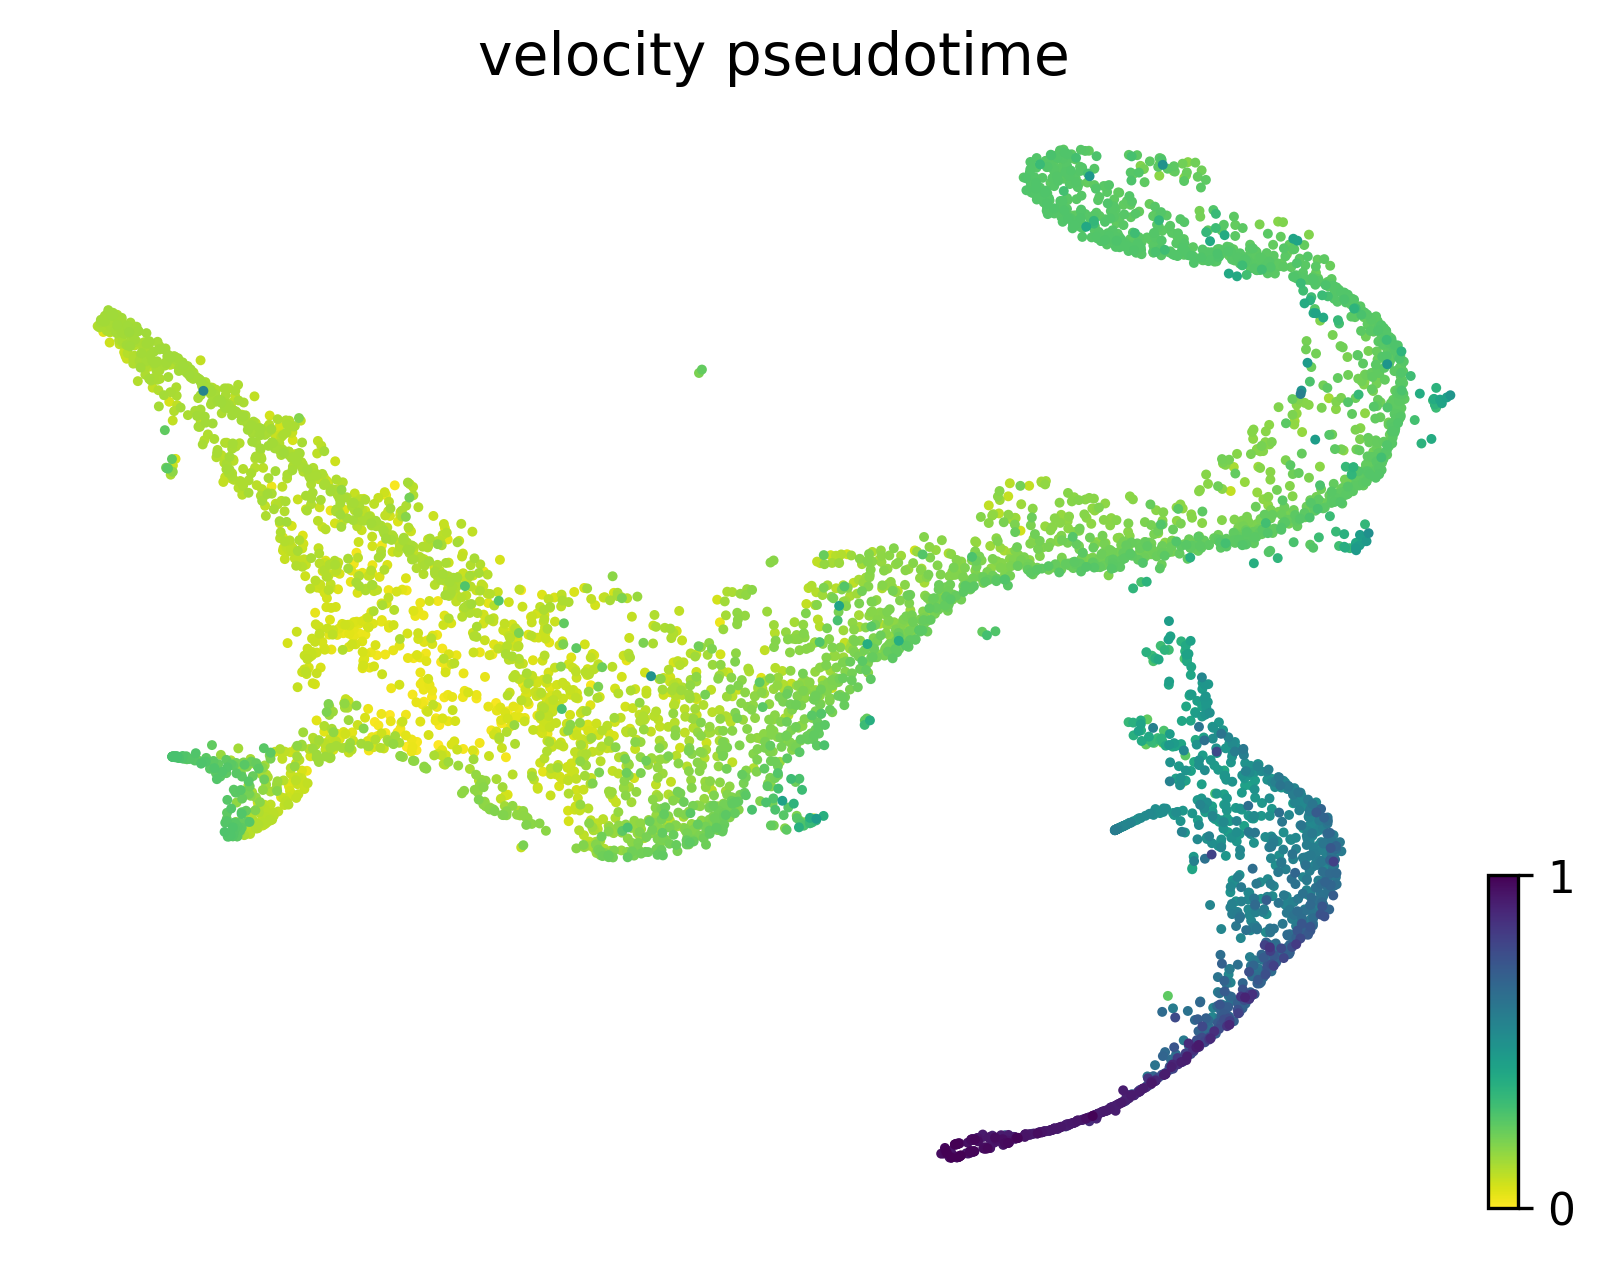

In [11]:
scv.pl.scatter(deepvelo_adata, basis = "tsne", color = "velocity_pseudotime", fontsize = 14, dpi = 300, save = "figure/deepvelo_bone_marrow_pseudotime.png")

## celldancer

saving figure to file figure/celldancer_bone_marrow_pseudotime.png


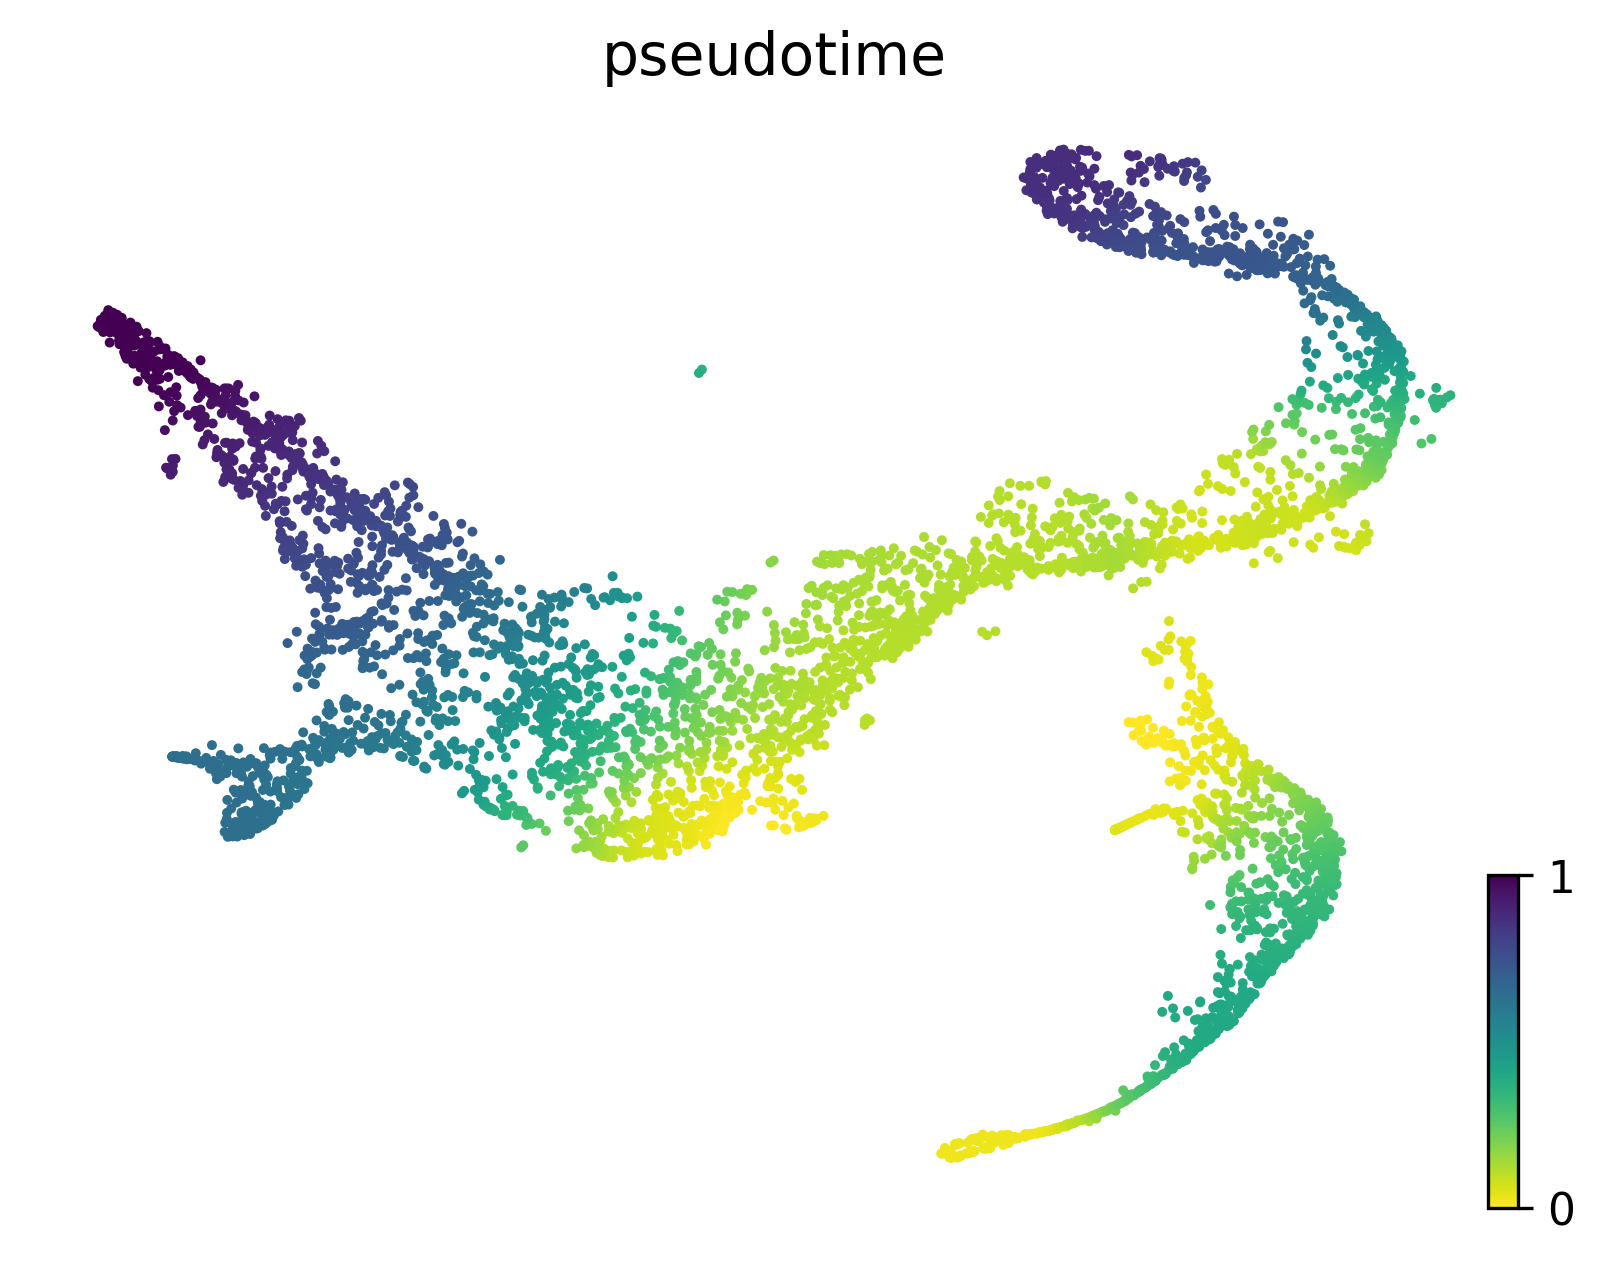

In [12]:
scv.pl.scatter(celldancer_adata, basis = "cdr", color = "pseudotime", fontsize = 14, dpi = 300, save = "figure/celldancer_bone_marrow_pseudotime.png")

## JuloVelo

saving figure to file figure/julovelo_bone_marrow_pseudotime.png


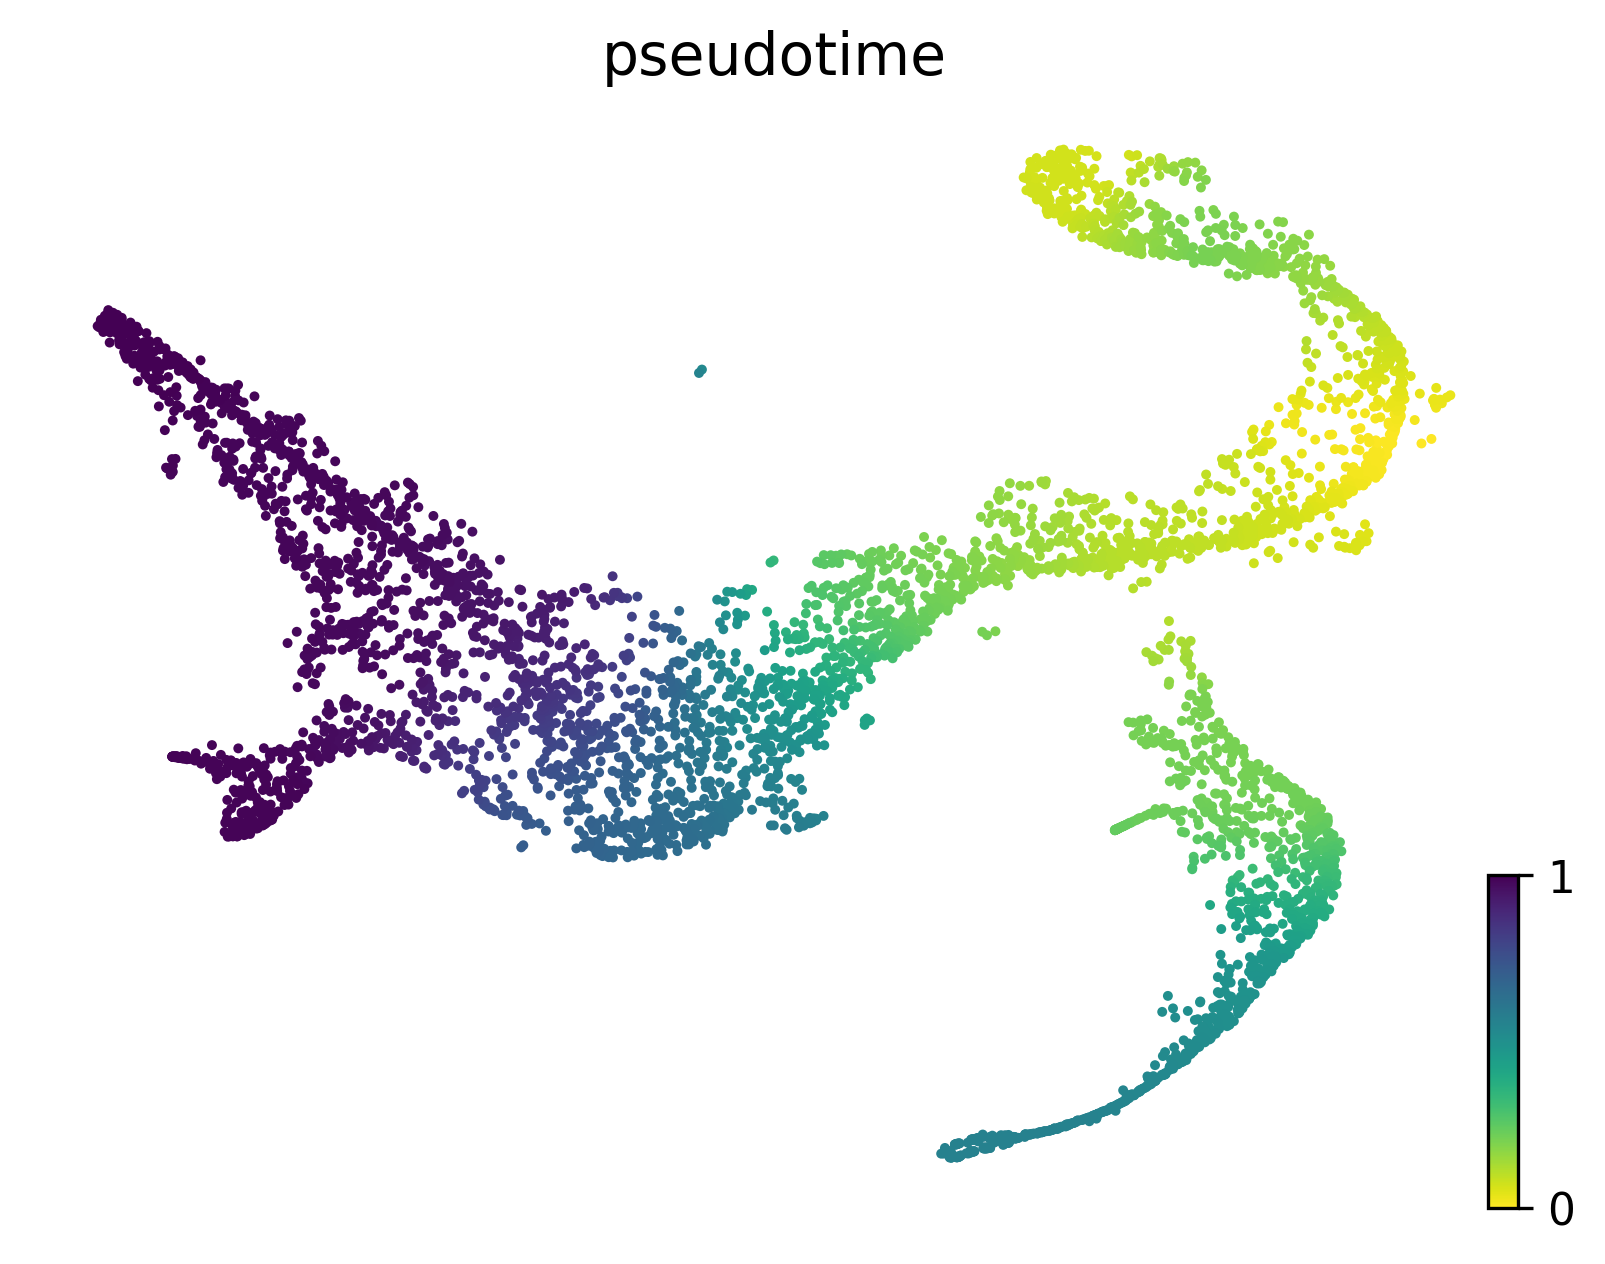

In [13]:
scv.pl.scatter(julovelo_adata, color = "pseudotime", fontsize = 14, dpi = 300, save = "figure/julovelo_bone_marrow_pseudotime.png")

# Heatmap

In [14]:
train_genes = julovelo_adata.var_names[julovelo_adata.var.train_genes]

In [15]:
alpha = julovelo_adata.uns["alpha"]
beta = julovelo_adata.uns["beta"]
gamma = julovelo_adata.uns["gamma"]
u = julovelo_adata.uns["train_u"]
s = julovelo_adata.uns["train_s"]

In [16]:
adata = ad.AnnData(u)

In [17]:
adata.var_names = train_genes
adata.obs["clusters"] = list(julovelo_adata.obs.clusters)
adata.obs["pseudotime"] = list(julovelo_adata.obs.pseudotime)

In [18]:
adata.layers["norm_u"] = u
adata.layers["norm_s"] = s
adata.layers["alpha"] = alpha

In [19]:
p1, p2 = plotting_sort(adata, "norm_u", "alpha", n_convolve = 200, col_color = "clusters", save = True, save_path = "figure/")

# Expression

In [20]:
genes = ["CD44", "TAOK3", "CELF2"]

saving figure to file figure/embedding_bone_marrow_spliced_pattern.png


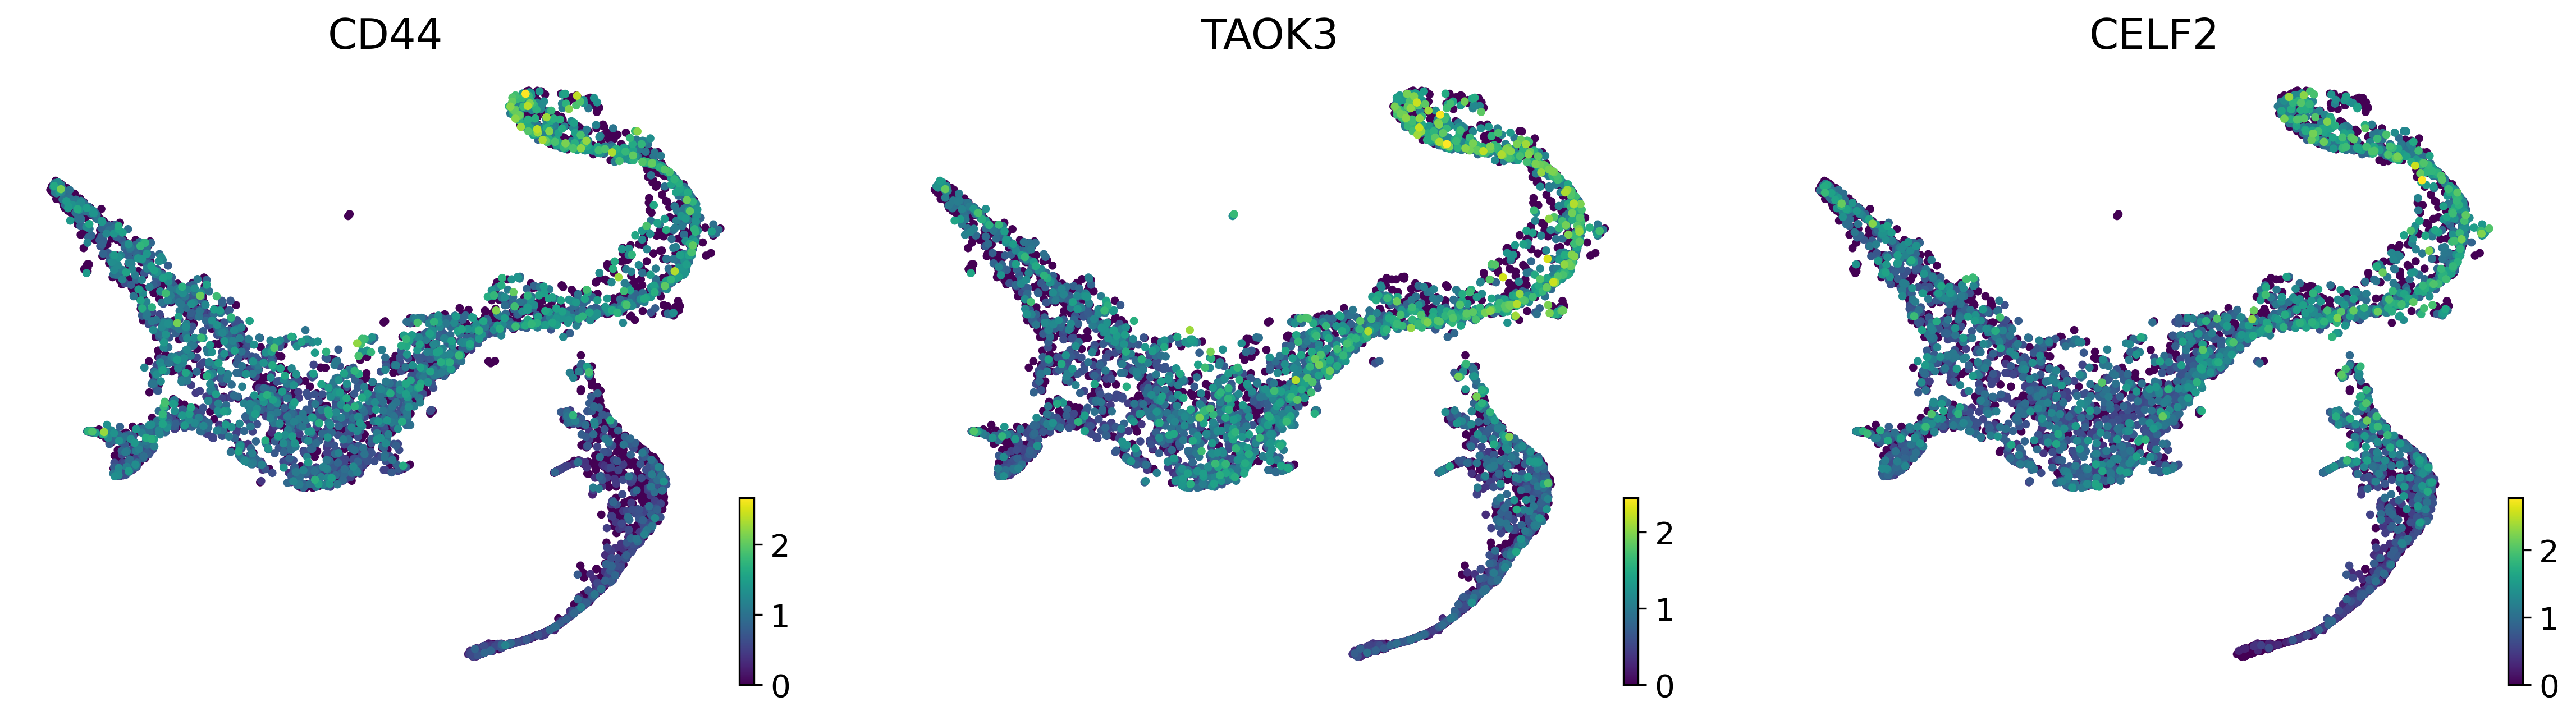

In [21]:
scv.pl.scatter(julovelo_adata, color = genes, size = 50, fontsize = 18, save = "figure/embedding_bone_marrow_spliced_pattern.png", dpi = 300)